In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_file ='/content/drive/MyDrive/MRI/'
    print(path_to_file)
    os.chdir(path_to_file)
    !pwd

Mounted at /content/drive
/content/drive/MyDrive/MRI/
/content/drive/.shortcut-targets-by-id/18kUscTVROpuRRXO8K2OHeX8nmGeUxn47/MRI


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 21.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import random

import logging
import tempfile
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from pytorch_lightning.callbacks import ModelCheckpoint

(640, 640, 3)


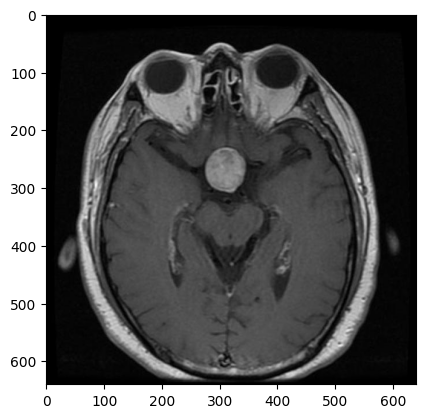

In [ ]:
sample_img = img.imread('/content/drive/MyDrive/MRI/train/images/Tr-pi_0659_jpg.rf.4eda5dc418881536be11cc1f7d613e83.jpg')
print(sample_img.shape)
plt.imshow(sample_img)
plt.show()

In [ ]:
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.functional import resize as TF_resize
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch

class BoundingBoxAndClassificationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_size=(224, 224)):
        self.image_files = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]
        self.label_files = [os.path.join(label_dir, os.path.basename(f).replace('.jpg', '.txt')) for f in self.image_files]
        self.transform = transform
        self.target_size = target_size  # target size for resizing images and masks
        self.prefix_to_class = {
            'Tr-pi': 0,  # Pituitary
            'Tr-me': 1,  # Meningioma
            'Tr-gl': 2,  # Glioma
            'Tr-no': 3   # No Tumor
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        filename = os.path.basename(self.image_files[index])
        image = Image.open(self.image_files[index]).convert('RGB')

        prefix = filename.split('_')[0]
        label = self.prefix_to_class[prefix]

        label_file_path = self.label_files[index]
        if not os.path.exists(label_file_path):
            raise FileNotFoundError(f"Label file not found: {label_file_path}")

        with open(label_file_path, 'r') as file:
            lines = file.readlines()
        masks = []
        bboxes = []  # List to store bounding boxes
        for line in lines:
            data = list(map(float, line.strip().split()))
            x_center = data[1]
            y_center = data[2]
            width = data[3]
            height = data[4]
            x = int((x_center - width / 2) * image.width)
            y = int((y_center - height / 2) * image.height)
            w = int(width * image.width)
            h = int(height * image.height)
            bbox = np.array([x, y, w, h])
            bboxes.append(bbox)  # Append bbox to list
            mask = np.zeros((image.height, image.width), dtype=np.uint8)
            mask[y:y+h, x:x+w] = 1
            masks.append(mask)

        combined_mask = np.max(np.stack(masks), axis=0) if masks else np.zeros((image.height, image.width), dtype=np.uint8)

        # Resize the image and mask using the same size but different methods
        image = TF_resize(image, self.target_size)
        combined_mask = Image.fromarray(combined_mask).resize(self.target_size, Image.NEAREST)
        combined_mask = np.array(combined_mask)

        if self.transform:
            image = self.transform(image)

        combined_mask = torch.tensor(combined_mask, dtype=torch.float32)  # Convert resized mask back to tensor
        if bboxes:
            bbox = np.stack(bboxes).mean(axis=0)  # Taking an average of all bboxes for simplicity

        return image, combined_mask, label, torch.tensor(bbox, dtype=torch.float32)




# Prepare image transformations
image_transformations = Compose([
    ToTensor(),  # Convert image to tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match the ViT pre-training
])
# directory paths
train_image_dir = '/content/drive/MyDrive/MRI/train/images'
train_label_dir = '/content/drive/MyDrive/MRI/train/labels'
val_image_dir = '/content/drive/MyDrive/MRI/valid/images'
val_label_dir = '/content/drive/MyDrive/MRI/valid/labels'
test_image_dir = '/content/drive/MyDrive/MRI/test/images'
test_label_dir = '/content/drive/MyDrive/MRI/test/labels'
# Initialize datasets with transformations and a specified resize target
train_dataset = BoundingBoxAndClassificationDataset(train_image_dir, train_label_dir, transform=image_transformations, target_size=(224, 224))
val_dataset = BoundingBoxAndClassificationDataset(val_image_dir, val_label_dir, transform=image_transformations, target_size=(224, 224))
test_dataset = BoundingBoxAndClassificationDataset(test_image_dir, test_label_dir, transform=image_transformations, target_size=(224, 224))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
# let's test the above functions using the same sample image to see if it works
# 0 0.575 0.4203125 0.0875 0.09375 #glioma
def find_image_index(dataset, filename):
    for i, filepath in enumerate(dataset.image_files):
        if filename in filepath:
            return i
    return -1

idx_test1 = find_image_index(train_dataset, 'Tr-pi_0659_jpg.rf.4eda5dc418881536be11cc1f7d613e83.jpg')
if idx_test1 != -1:
    image1, mask1, label1, bbox1 = train_dataset[idx_test1]  # Include bbox1 in the unpacking

    if isinstance(image1, torch.Tensor):
        image1 = image1.permute(1, 2, 0).numpy()
        image1 = np.clip(image1, 0, 1)

    if isinstance(mask1, torch.Tensor):
        mask1 = mask1.numpy()

    class_names = {
        0: 'Pituitary',
        1: 'Meningioma',
        2: 'Glioma',
        3: 'No Tumor'
    }

    tumor_type = class_names[label1]

    # Optionally print or use bbox1 if needed
    print(f"Tumor Type: {tumor_type}")
    print(f"Bounding Box: {bbox1}")


import matplotlib.pyplot as plt
import matplotlib.patches as patches



Tumor Type: Pituitary
Bounding Box: tensor([267., 224.,  89.,  82.])


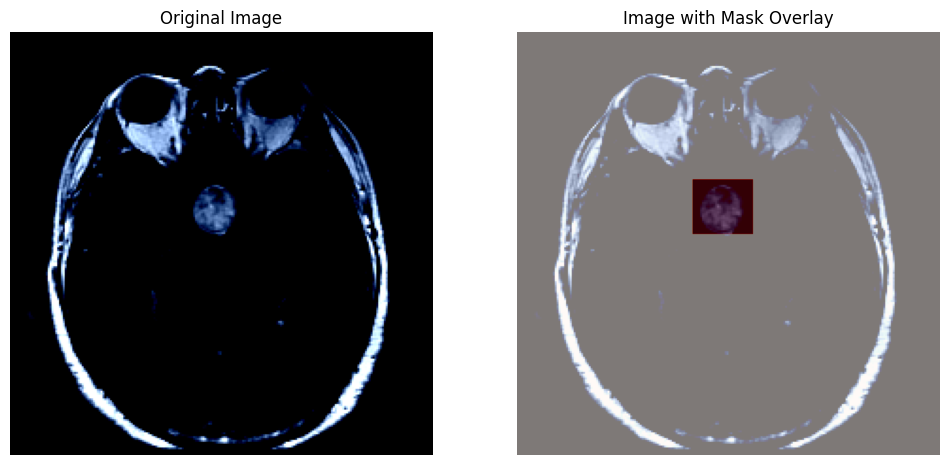

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)  # Show the original image
ax[0].set_title('Original Image')
ax[0].axis('off')

# Overlay the mask on the original image
ax[1].imshow(image1)  # First, show the image
ax[1].imshow(mask1, alpha=0.5, cmap='Reds')  # Then, overlay the mask
ax[1].set_title('Image with Mask Overlay')
ax[1].axis('off')
plt.show()


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch
import timm
import pytorch_lightning as pl
import torchmetrics
from torch.optim.lr_scheduler import StepLR
class VisionTransformerWithBBox(pl.LightningModule):
    def __init__(self, n_classes, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # Load a pre-trained Vision Transformer model
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)  # No classification head
        self.backbone.head = nn.Identity()  # Remove the original classification head

        # New classification head
        self.classification_head = nn.Linear(self.backbone.num_features, n_classes)
        # Bounding box regression head
        self.bbox_head = nn.Linear(self.backbone.num_features, 4)

        # Loss functions
        self.class_loss_function = nn.CrossEntropyLoss()
        self.bbox_loss_function = nn.SmoothL1Loss()

        # Metrics
        self.f1_score = torchmetrics.F1Score(num_classes=n_classes, average='macro', task='multiclass')
        self.precision = torchmetrics.Precision(num_classes=n_classes, average='macro', task='multiclass')
        self.recall = torchmetrics.Recall(num_classes=n_classes, average='macro', task='multiclass')
    def freeze_backbone(self, freeze=True):
            for param in self.backbone.parameters():
                param.requires_grad = not freeze

    def on_train_start(self):
            self.freeze_backbone()  # Initially freeze the backbone

    def on_train_epoch_end(self, unused=None, outputs=None):
        # Example of processing outputs if necessary
        if outputs:
            average_loss = torch.stack([x['loss'] for x in outputs]).mean()
            self.log('avg_train_loss', average_loss)

        # Handling layer unfreezing
        if self.current_epoch == 10:
            self.freeze_backbone(freeze=False)


    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.01)

    def forward(self, x):
        features = self.backbone(x)
        class_logits = self.classification_head(features)
        bbox_coords = self.bbox_head(features)
        return class_logits, bbox_coords

    def training_step(self, batch, batch_idx):
        x, _, y, bbox_true = batch
        class_logits, bbox_preds = self(x)
        class_loss = self.class_loss_function(class_logits, y)
        bbox_loss = self.bbox_loss_function(bbox_preds, bbox_true)
        loss = class_loss + bbox_loss  # Combine losses; may use different weighting

        preds = torch.argmax(class_logits, dim=1)
        self.log_dict({
            'train_loss': loss,
            'train_class_loss': class_loss,
            'train_bbox_loss': bbox_loss,
            'train_f1_score': self.f1_score(preds, y),
            'train_precision': self.precision(preds, y),
            'train_recall': self.recall(preds, y)
        }, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, _, y, bbox_true = batch
        class_logits, bbox_preds = self(x)
        class_loss = self.class_loss_function(class_logits, y)
        bbox_loss = self.bbox_loss_function(bbox_preds, bbox_true)
        loss = class_loss + bbox_loss  # Combine losses; may use different weighting

        preds = torch.argmax(class_logits, dim=1)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_class_loss', class_loss, prog_bar=True)
        self.log('test_bbox_loss', bbox_loss, prog_bar=True)
        self.log('test_f1_score', self.f1_score(preds, y), prog_bar=True)
        self.log('test_precision', self.precision(preds, y), prog_bar=True)
        self.log('test_recall', self.recall(preds, y), prog_bar=True)


        # Optionally, return predictions for further analysis outside of logging
        return x, bbox_true, preds, bbox_preds, y





# You would then instantiate and train this model just like before:
model_with_bbox = VisionTransformerWithBBox(n_classes=4, learning_rate=1e-3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(self, train_loader, val_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader

In [ ]:
class_data_module = ClassificationDataModule(train_loader, val_loader, test_loader)

class_trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[ModelCheckpoint(monitor='val_loss')]
)


class_trainer.fit(model_with_bbox, class_data_module)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | backbone            | VisionTransformer   | 85.8 M
1 | classification_head | Linear              | 3.1 K 
2 | bbox_head           | Linear              | 3.1 K 
3 | class_loss_function | CrossEntropyLoss    | 0     
4 | bbox_loss_function  | Smo

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_class_loss', 'train_class_loss_step', 'train_bbox_loss', 'train_bbox_loss_step', 'train_f1_score', 'train_f1_score_step', 'train_precision', 'train_precision_step', 'train_recall', 'train_recall_step', 'train_loss_epoch', 'train_class_loss_epoch', 'train_bbox_loss_epoch', 'train_f1_score_epoch', 'train_precision_epoch', 'train_recall_epoch', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# # Save the entire model
# torch.save(model_with_bbox, 'complete_model_v2_FTF.pth')


In [ ]:
# Assuming `class_trainer` is your Trainer instance and `model_class` is your trained model
result = class_trainer.test(model_with_bbox, dataloaders=class_data_module.test_dataloader())
print(result)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_bbox_loss       │     50.47150802612305     │
│      test_class_loss      │    0.27848726511001587    │
│       test_f1_score       │    0.8371402025222778     │
│         test_loss         │     50.75000762939453     │
│      test_precision       │     0.859078586101532     │
│        test_recall        │    0.8218157291412354     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 50.75000762939453, 'test_class_loss': 0.27848726511001587, 'test_bbox_loss': 50.47150802612305, 'test_f1_score': 0.8371402025222778, 'test_precision': 0.859078586101532, 'test_recall': 0.8218157291412354}]
